# From Concept to Model 

In [294]:

# Common Import

import tensorflow as tf
import matplotlib.pyplot as plt # for visualization.
import numpy as np              # Low-level numerical Python library.
import pandas as pd             # Higher-level numerical Python library.
from matplotlib import cm
from matplotlib import gridspec
from numpy import linspace
import sklearn.metrics as metrics
import math



<p><b> Important Terminologies</b></p>
<p><b>Steps</b> : which is the total number of training iterations. One step calculates the loss from one batch and uses that value to modify the model's weights once.</p>
<p><b>Batch size: </b> which is the number of examples (chosen at random) for a single step.</p>

<p> From this two terminologies, we know that: </p>
$$total\_number\_of\_trained\_examples = batchsize*steps$$

<p><b>Periods: </b> controls the granularity of reporting. For example, if periods is set to 10 and steps is set to 100, then the exercise will output the loss value every 10 steps (or 10 times). Note that modifying periods does not alter what your model learns.</p>



# Exploratory Data Analysis

<p> We wish to learn something about our data set before we can go on to build models for predictions. The Ipython Pandas Library will come very useful here</p>

In [70]:
# We import data using pandas. Note that pandas library is already in our import list. check cell one
# 
california_data_test = pd.read_csv("housing.csv", nrows=100)

float_cols = [c for c in df_test if california_data_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

# Read and convert float64  to float32 . This is to prevent warning in tensorflow.
california_data = pd.read_csv("housing.csv", engine='c', dtype=float32_cols)

In [71]:
# Let us view the first few data set
california_data[0:1]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY


In [72]:
# The imported data is now a pandas dataframe which is a fancy name for table

#  We provide a general statistical description of the dataframe as below
california_data.describe()


//anaconda/envs/seychelles/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.00000
mean,-119.569115,35.631866,28.639486,2635.758789,537.870544,1425.477905,499.539673,3.870662,206854.96875
std,2.003539,2.135956,12.585629,2181.604736,421.384338,1132.460815,382.329773,1.899820,115395.18750
min,-124.349998,32.540001,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.00000
25%,-121.800003,33.930000,18.000000,1447.750000,NaN,787.000000,280.000000,2.563400,119600.00000
50%,-118.489998,34.259998,29.000000,2127.000000,NaN,1166.000000,409.000000,3.534800,179700.00000
75%,-118.010002,37.709999,37.000000,3148.000000,NaN,1725.000000,605.000000,4.743250,264725.00000
max,-114.309998,41.950001,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.00000


In [75]:
# Lets also report the shape of the dataframe
print ("The shape of data  is : ", california_data.shape)

The shape of data  is :  (20640, 10)


In [76]:
#Lets check the number of columns we have 
print ("The columns in the data set is : ")
print (california_data.columns.values)

The columns in the data set is : 
['longitude' 'latitude' 'housing_median_age' 'total_rooms' 'total_bedrooms'
 'population' 'households' 'median_income' 'median_house_value'
 'ocean_proximity']


In [77]:
#We should check for Null data.
#This is an important step in exploratory data analysis

california_data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [78]:
# We replace null values in total_bedrooms with the median
california_data["total_bedrooms"].fillna(california_data["total_bedrooms"].median(),inplace = True)

In [79]:
# A call to check null values return zero for all
california_data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

<p>Let us randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of our model</p>

In [80]:
# We randomize the data by using reindexing 
california_data = california_data.reindex(
    np.random.permutation(california_data.index))

In [81]:
california_data[0:2] # We can see that the data set has been randomized !

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4541,-118.199997,34.029999,37.0,1583.0,392.0,1776.0,377.0,2.7266,140800.0,<1H OCEAN
10211,-117.910004,33.889999,30.0,1631.0,212.0,523.0,216.0,7.8750,351900.0,<1H OCEAN


# Build Models

    * we'll be trying to predict median_house_value. This is the so called target variable
    * total_rooms will be be input feature (called feature set)
    * we'll build a Linear regression model using TensorFlow Library 
    * We will use GradientDescentOptimizer implements Mini-Batch Stochastic Gradient Descent (SGD)
    * The size of the  mini-batch will be given by the batch_size parameter
    * learning_rate parameter  controls the size of the gradient step to the optimizer
    



<p>We extract the feature set and target variable from the data frame. </p>

In [82]:
# Collect the feature input variable from the data set
my_feature = california_data["total_rooms"] 

# Collect the output/ target variable from the data set
targets = california_data["median_house_value"]



In [174]:
my_feature_new = my_feature.values; # extract feature values

In [176]:
targets_new = targets.values; # Extract target values

<p><b> Normalize datset</b> </p>

In [189]:
def normalize(array):
    return (array - array.mean()) / array.std()

In [230]:
my_new_feature_norm = normalize(my_feature_new) # Normalize input/ feature set

In [229]:
targets_new_norm = normalize(targets_new)  # normalize target variable

<p> <b> Make Validationa and test set </b> </p>

In [233]:
#img_size=10;
VALIDATION_SIZE = 200

test_X = my_new_feature_norm[:VALIDATION_SIZE]
test_Y = targets_new_norm[:VALIDATION_SIZE]

train_X = my_new_feature_norm[VALIDATION_SIZE:]
train_Y = targets_new_norm[VALIDATION_SIZE:]


print("trianing set input shape: " ,train_X.shape)
print("test set input shape: ",test_X.shape)


trianing set input shape:  (20440,)
test set input shape:  (200,)


<p> <b>Batch Function</b></p>
<p>Below is a function to generate seperate batch for each iteration</p>

In [256]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_X.shape[0]

def next_batch(batch_size):
    
    global train_X
    global train_Y
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_X = train_X[perm]
        train_Y = train_Y[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_X[start:end], train_Y[start:end]

<p><b> Set Model Parameters for tensorFlow </b></p>

In [ ]:
#from sklearn.model_selection import train_test_split
# Parameters
learning_rate = 0.001
training_epochs = 5
display_step = 1
SEED = 500
BATCH_SIZE = 100;

#Number of samples and random number generation
n_samples = train_X.shape[0]
rng = np.random


#Use place holders to hold your variables
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights and bias

W = tf.Variable(rng.randn(), name="weight")
b = tf.Variable(rng.randn(), name="bias")




# Construct a linear model
pred = tf.add(tf.mul(X, W), b)



# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)



# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)






<p><b> Train model </b><p>

Epoch: 0001 cost= 1.022631526 W= 0.758541 b= -0.822192
Epoch: 0002 cost= 1.021596789 W= 0.757963 b= -0.821367
Epoch: 0003 cost= 1.020563602 W= 0.757386 b= -0.820543
Epoch: 0004 cost= 1.019529939 W= 0.75681 b= -0.81972
Epoch: 0005 cost= 1.018501997 W= 0.756234 b= -0.818897
Optimization Finished!
Training cost= 1.0185 W= 0.756234 b= -0.818897 



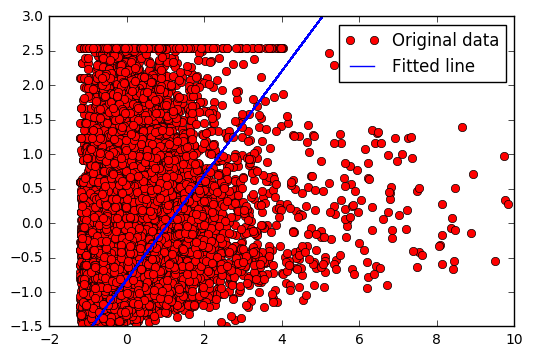

Testing... (Mean square loss Comparison)
Testing cost= 1.15144
Absolute mean square loss difference: 0.132934


In [293]:
# Initializing the variables
init = tf.initialize_all_variables()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        #batch_xs, batch_ys = next_batch(BATCH_SIZE)
        batch_xs, batch_ys = next_batch(BATCH_SIZE) 
        # Use batch_xs and batch_ys instead
        #of train_X and train 
        for (x, y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={X: train_X, Y:train_Y})
            #print(len(train_Y))
            #predict = sess.run(pred, feed_dict={X: train_X, Y:train_Y})
            #print(predict.shape)

            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                "W=", sess.run(W), "b=", sess.run(b))

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
    
    print("Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b),'\n')

    # Graphic display
    fig, ax = plt.subplots()
    
    ax.plot(train_X, train_Y, 'ro', label='Original data')
    ax.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')
    ax.set_ylim((-1.5, 3))
    ax.set_xlim((-2, 10))
    plt.legend()
    plt.show()

    print("Testing... (Mean square loss Comparison)")
    testing_cost = sess.run(
        tf.reduce_sum(tf.pow(pred - Y, 2)) / (2 * test_X.shape[0]),
        feed_dict={X: test_X, Y: test_Y})  # same function as cost above
    print("Testing cost=", testing_cost)
    print("Absolute mean square loss difference:", abs(
        training_cost - testing_cost))
    
    # Implement accuracy 
    
    
    #Uncomment to make use of this 
    #fig = plt.figure()
    # plot 1
    #ax1 = fig.add_subplot(211)
    #ax1.set_ylim((-2, 2))
    #ax1.set_xlim((0.5, 10.5))
    #ax1.plot(test_X, test_Y, 'bo', label='Testing data')
    
    # Plot 2
    #ax2 = fig.add_subplot(212)

    #ax2.set_ylim((-3, 3))
    #ax2.set_xlim((0.5, 10))
    #ax2.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')

    #plt.legend()
    #plt.show()

# Improving the model

    * Incresase the iteration time
    * replace train_y  and train_x in the ieration loop with (batch_xs and batch_xy)
    * change weight values
    * Do other parameter tunning as necessary
    